# **0. 참고자료**
## **0-1. 도서**    

## **0-2. 논문, 학술지**

## **0-3. 웹 사이트**
- DACON 코드공유 - 데이터 확인과 회전에 의한 데이터 증강 | [[링크]](https://dacon.io/competitions/official/235951/codeshare/5906?page=1&dtype=recent)

## **0-4. 데이터셋 출처**
- DACON - 숫자 3D 이미지 분류 AI 경진대회 | [[데이터 셋 링크]](https://dacon.io/competitions/official/235951/data)

# **1. 필요한 패키지 로딩**

In [35]:
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import h5py

# **2. 데이터 확인해 보기**
## **2-1. 데이터 로드**
→ 학습 데이터 셋 csv에는 이미지 인덱스 : 라벨값으로 구성되어 있다.  
→ 시험 데이터 셋 csv에는 이미지 인덱스 : 더미 라벨값으로 구성되어 있다.

In [2]:
points  = h5py.File('datasets/train.h5', 'r')
dataset = pd.read_csv ('datasets/train.csv')

In [3]:
test_df = pd.read_csv('datasets/sample_submission.csv')
test_points = h5py.File('datasets/test.h5', 'r')

- 데이터 처리 용이성을 위해 point들을 numpy array형으로 변환한다.

In [24]:
train_all = [np.array(points[str(idx)]) for idx in tqdm(dataset['ID'])]
test_all = [np.array(test_points[str(i)]) for i in tqdm(test_df['ID'])]

100%|██████████| 40000/40000 [01:50<00:00, 361.60it/s]


In [36]:
def show_voxel(points, idx = None):
    fig = plt.figure(figsize = (5,5))
    ax = fig.add_subplot(111, projection = '3d')

    x = points[:, 0] if idx == None else points[idx][:, 0]
    y = points[:, 1] if idx == None else points[idx][:, 1]
    z = points[:, 2] if idx == None else points[idx][:, 2]

    ax.view_init(0, 0)
    ax.scatter(x, y, z)
    
def rotate(theta_x, theta_y, theta_z, dots):
    mx = np.array([[1, 0, 0], [0, np.cos(theta_x), -np.sin(theta_x)], [0, np.sin(theta_x), np.cos(theta_x)]])
    my = np.array([[np.cos(theta_y), 0, np.sin(theta_y)], [0, 1, 0], [-np.sin(theta_y), 0, np.cos(theta_y)]])
    mz = np.array([[np.cos(theta_z), -np.sin(theta_z), 0], [np.sin(theta_z), np.cos(theta_z), 0], [0, 0, 1]])
    
    m = np.dot(np.dot(mx,my),mz)
    dots = np.dot(dots, m.T)
    
    return dots


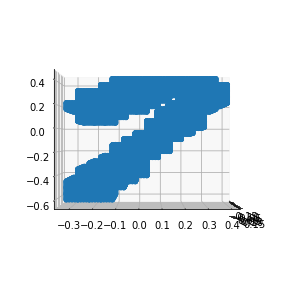

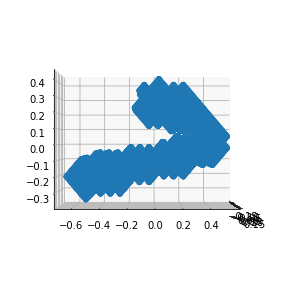

In [37]:
show_voxel(train_all, 9999)

new_dot = rotate(-np.pi/4, 0, 0, train_all[9999])
show_voxel(new_dot)

In [3]:
train_df = dataset.iloc[:int(len(dataset)*0.8)]
val_df = dataset.iloc[int(len(dataset)*0.8):]

train_lb = train_df['label']
valid_lb = val_df['label']

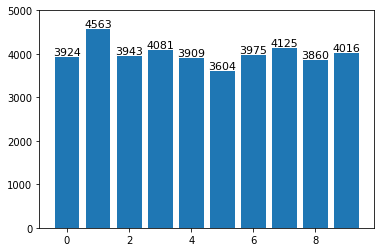

In [4]:
def get_graph(data):
    plt.bar(data.keys(), data.values())
    plt.ylim(0, 5000)

    for cnt, num in data.items():
        plt.text(cnt, num, num,
                fontsize = 11, color = 'black',
                horizontalalignment = 'center',
                verticalalignment   = 'bottom')
        
get_graph(Counter(train_lb))

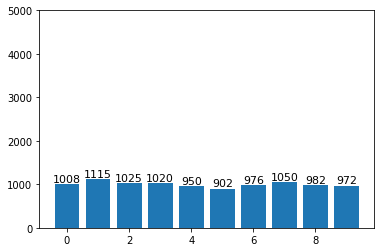

In [5]:
get_graph(Counter(valid_lb))

In [6]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import torch

/opt/conda/envs/bio/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
EPOCHS        = 30
BATCH_SIZE    = 16
LEARNING_RATE = 1e-4

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
class CustomDataset(Dataset):
    def __init__(self, indexes, labels, points):
        self.indexes = indexes
        self.labels  = labels
        self.points  = points
        
    def __getitem__(self, index):
        
        idx    = self.indexes[index]
        points = self.points[str(idx)][:]
        image  = self.get_vector(points)
    
        if self.labels is not None:
            label = dataset['label'][idx]
            return torch.Tensor(image).unsqueeze(0), label
        
        else:
            return torch.Tensor(image).unsqueeze(0)
        
    def get_vector(self, points, x_y_z = [16, 16, 16]):
        
        xyzmin = np.min(points, axis = 0) - 0.001
        xyzmax = np.max(points, axis = 0) + 0.001
        
        diff   = max(xyzmax-xyzmin) - (xyzmax - xyzmin)
        xyzmin = xyzmin - diff / 2
        xyzmax = xyzmax + diff / 2
        
        segments, shape = [], []
        for i in range(3):
            
            if type(x_y_z[i]) is not int: raise TypeError(f'x_y_z[{i}] must be int')
            
            s, step = np.linspace(xyzmin[i], xyzmax[i], num = (x_y_z[i] + 1), retstep = True)
            segments.append(s)
            shape.append(step)
        
        n_voxels = x_y_z[0] * x_y_z[1] * x_y_z[2]
        n_x      = x_y_z[0]
        n_y      = x_y_z[1]
        n_z      = x_y_z[2]
        
        structure = np.zeros((len(points), 4), dtype = int)
        structure[:,0] = np.searchsorted(segments[0], points[:,0]) - 1
        structure[:,1] = np.searchsorted(segments[1], points[:,1]) - 1
        structure[:,2] = np.searchsorted(segments[2], points[:,2]) - 1

        # i = ((y * n_x) + x) + (z * (n_x * n_y))
        structure[:,3] = ((structure[:,1] * n_x) + structure[:,0]) + (structure[:,2] * (n_x * n_y))
        
        vector = np.zeros(n_voxels)
        count = np.bincount(structure[:,3])
        vector[:len(count)] = count

        vector = vector.reshape(n_z, n_y, n_x)
        return vector

    def __len__(self):
        return len(self.indexes)

In [10]:
train_dataset = CustomDataset(train_df['ID'].values, train_df['label'].values, points)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_df['ID'].values, val_df['label'].values, points)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [11]:
train_sample = iter(train_loader)
image, _     = next(train_sample)

image.size()

torch.Size([16, 1, 16, 16, 16])

In [12]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel,self).__init__()
        self.feature_extract = nn.Sequential(
            nn.Conv3d(1,8,3),
            nn.ReLU(),
            nn.BatchNorm3d(8),
            nn.Conv3d(8,32,3),
            nn.ReLU(),
            nn.BatchNorm3d(32),
            nn.MaxPool3d(4),
            nn.Conv3d(32,128,3),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
                                nn.Linear(128, 64),
                                nn.ReLU(),
                                nn.Dropout(p = 0.3),
                                nn.Linear(64, 32),
                                nn.ReLU(),
                                nn.Dropout(p = 0.3),
                                nn.Linear(32, 10)
                            )

    def forward(self,x):
        x = self.feature_extract(x)
        x = x.view(x.size()[0],-1)
        x = self.classifier(x)
        return x

In [13]:
class ResidualBlock(nn.Module):
    
    def __init__(self, in_planes, planes, stride = 1):
        
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1   = nn.BatchNorm3d(planes)
        
        self.conv2 = nn.Conv3d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2   = nn.BatchNorm3d(planes)
        
        self.shortcut = nn.Sequential()
        condition = [stride != 1, in_planes != planes]
        
        if any(condition):
            self.shorcut = nn.Sequential(
                            nn.Conv3d(in_planes, planes, kernel_size = 1, stride = stride,
                                        bias = False),
                            nn.BatchNorm3d(planes)
                        )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        out += self.shortcut(x)
        out = F.relu(out)
        
        return out

In [19]:
class ResNetV(nn.Module):
    
    def __init__(self, num_classes = 10):
        
        super(ResNetV, self).__init__()
        self.in_planes = 16
        
        self.conv1 = nn.Conv3d(1, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1   = nn.BatchNorm3d(16)
        
        self.residual1 = self._make_block(16, 2, stride = 1)
        self.residual2 = self._make_block(32, 2, stride = 2)
        self.residual3 = self._make_block(64, 2, stride = 2)
        self.linear    = nn.Linear(64, num_classes)
       
    
    def _make_block(self, planes, num_blocks, stride):
        
        strides = [stride] + []*(num_blocks - 1)
        layers  = []
        
        for stride in strides:
            layers.append(ResidualBlock(self.in_planes, planes, stride))
            self.in_planes = planes
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.residual1(out)
        out = self.residual2(out)
        out = self.residual3(out)
        
        out = F.avg_pool3d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out

In [15]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    best_score = 0
    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_loss = []
        for data, label in train_loader:
            data, label = data.float().to(device), label.long().to(device)
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        if scheduler is not None:
            scheduler.step()
            
        val_loss, val_acc = validation(model, criterion, val_loader, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss)}] Val Loss : [{val_loss}] Val ACC : [{val_acc}]')
        
        if best_score < val_acc:
            best_score = val_acc
            torch.save(model.state_dict(), './best_model.pth')

In [16]:
def validation(model, criterion, val_loader, device):
    model.eval()
    true_labels = []
    model_preds = []
    val_loss = []
    with torch.no_grad():
        for data, label in tqdm(iter(val_loader)):
            data, label = data.float().to(device), label.long().to(device)
            
            model_pred = model(data)
            loss = criterion(model_pred, label)
            
            val_loss.append(loss.item())
            
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()
    
    return np.mean(val_loss), accuracy_score(true_labels, model_preds)

In [17]:
model = ResNetV()
model

ResNetV(
  (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (residual1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (residual2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), paddin

In [18]:
model = ResNetV()
model.eval()

optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE)
scheduler = None

train(model, optimizer, train_loader, val_loader, scheduler, device)

RuntimeError: The size of tensor a (8) must match the size of tensor b (16) at non-singleton dimension 4

In [45]:
test_dataset = CustomDataset(test_df['ID'].values, None, test_points)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [46]:
checkpoint = torch.load('./best_model.pth')
model = BaseModel()
model.load_state_dict(checkpoint)
model.eval()

BaseModel(
  (feature_extract): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (4): ReLU()
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool3d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (7): Conv3d(32, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (8): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [47]:
def predict(model, test_loader, device):
    model.to(device)
    model.eval()
    model_preds = []
    with torch.no_grad():
        for data in tqdm(iter(test_loader)):
            data = data.float().to(device)
            
            batch_pred = model(data)
            
            model_preds += batch_pred.argmax(1).detach().cpu().numpy().tolist()
    
    return model_preds

In [48]:
preds = predict(model, test_loader, device)

100%|██████████| 2500/2500 [03:16<00:00, 12.73it/s]


In [49]:
test_df['label'] = preds
test_df.to_csv('submit/submit.csv', index=False)